c:\Users\32697\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32697\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\32697/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:39<00:00, 14.4MB/s] 


torch.Size([1, 1000])


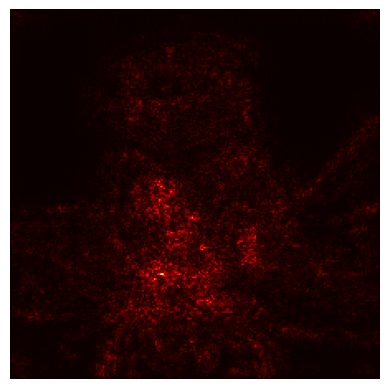

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image

def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)

def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

if __name__ =='__main__':
    model = torchvision.models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    download("https://bkimg.cdn.bcebos.com/pic/3bf33a87e950352ac65cae81db13ecf2b21192131da3?x-bce-process=image/format,f_auto/quality,Q_70/resize,m_lfit,limit_1,w_536","input.jpg")
    img = Image.open('input.jpg') # 这里可以替换为自己的图片 

    X = preprocess(img) # X.shape: 1, 3, 224, 224
    model.eval()
    X.requires_grad_()
    output = model(X) # 1, 1000 
    print(output.shape)
    score_max_index = output.argmax()
    score_max = output[0, score_max_index]

    
    # a) 通过反向传播获取梯度
    score_max.backward()  # 对得分最高的类别进行反向传播
    gradients = X.grad.data  # 获取输入图片的梯度 (1, 3, 224, 224)

    # b) 在RGB通道上取梯度绝对值的最大值
    saliency, _ = torch.max(gradients.abs(), dim=1)  # 取 RGB 通道的最大值 (1, 224, 224)

    saliency = saliency.cpu().numpy()  # 转换为 NumPy 数组
    


    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.savefig("output.png")